In [1]:
# %load /Users/Jonathan/.je.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob
from os.path import join, isfile
# -------------------------------------------------------------------------------------
from nilearn import plotting, image;
from nilearn.masking import compute_epi_mask
import nibabel as nib
from nilearn.input_data import NiftiMasker
import time
# -------------------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score
from sklearn.feature_selection import SelectPercentile, f_classif
# -------------------------------------------------------------------------------------
plt.rcParams['figure.figsize'] = 12,6

/home/jerez/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [1]:
# SUBJECTS = ['S08']
SUBJECTS = ['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10','S11','S12']
RUNS = range(1,7)
PATH = '/imaging/ourlab/jerez/memcon/'
PERCENTILE = 5
CV = 5

In [3]:
from helper_functions import apply_niftiMasker, load_scanning_session_matrix, get_onsets
from classification import compute_classification

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# compute_mask(SUBJECTS)
# masker = compute_mask(SUBJECTS)

nilearn.input_data.nifti_masker.NiftiMasker

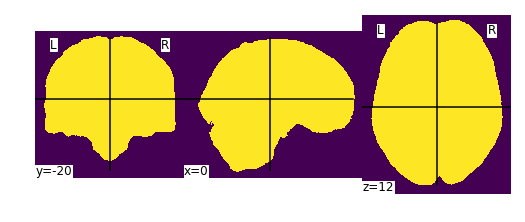

In [6]:
# load mask
mask = nib.load('12_subject_mask.nii')
plotting.plot_img(mask)
masker = NiftiMasker(mask_img = mask, standardize=True, memory="nilearn_cache", memory_level=1)
type(masker)

In [7]:
type(masker)

nilearn.input_data.nifti_masker.NiftiMasker

In [8]:
RUNS = RUNS[3:]

##-------##-------##-------##-------##-------##-------##-------##-------##-------##-------##-------##-------##-------

## Leave one subject out cross validation

In [9]:
from sklearn.metrics import accuracy_score
df = pd.DataFrame(columns=['Subject','classification_accuracy','classification_accuracy_reshuffled'])
SUBJECTS = ['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10','S11','S12']

svc = SVC(kernel='linear')
feature_selection = SelectPercentile(f_classif, percentile=PERCENTILE)
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [10]:
df_multi_subject = pd.DataFrame() # a multi-subject dataframe of [subject_number,onsets,brain_voxels]
for i,s in enumerate(SUBJECTS):
    if s == 'S11':
        RUNS = range(4,6)
    else:
        RUNS = range(4,7)
    print s,
    if not isfile(join(PATH,'data/Z_files',s + '_Z_GM.npy')): # Z file from Group Mask
        apply_niftiMasker_GM(s,RUNS,masker)
    single_subject_Z = load_scanning_session_matrix(s,GM = True)
    single_subject_onsets = get_onsets(s,RUNS)
            
    if RUNS == [4,5,6] or RUNS == [4,5]:
        single_subject_Z = single_subject_Z[48:,:]
        if single_subject_Z.shape[0] == 47:
            single_subject_onsets = single_subject_onsets[:-1] # dorp last row (subject S04)
    
    df_single_subject = pd.concat([pd.Series([s] * single_subject_onsets.shape[0]),single_subject_onsets['category'],pd.DataFrame(single_subject_Z)],axis = 1)
    df_multi_subject = pd.concat([df_multi_subject,df_single_subject],axis = 0)

S01 (96, 1645399)
4 5 6       onset  duration   category
0    0.0000        30        own
1   34.8847        30      other
2   69.9024        30  bookstore
3  104.9205        30        own
4  139.8885        30      other


helper_functions.py:167: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(join(PATH,onsets),sep='\s',header=None)


S02 (96, 1645399)
4 5 6       onset  duration   category
0    0.0000        30  bookstore
1   33.8862        30        own
2   68.7645        30      other
3  103.8759        30        own
4  138.7552        30      other
S03 (96, 1645399)
4 5 6       onset  duration   category
0    0.0000        30  bookstore
1   33.9732        30        own
2   68.8501        30      other
3  103.6816        30      other
4  138.6321        30        own
S04 (95, 1645399)
4 5 6       onset  duration   category
0    0.0000        30  bookstore
1   33.5042        30        own
2   68.5139        30      other
3  103.5134        30      other
4  138.7705        30        own
S05 (96, 1645399)
4 5 6       onset  duration   category
0    0.0000        30  bookstore
1   33.6790        30        own
2   68.6738        30      other
3  103.6817        30  bookstore
4  138.6472        30      other
S06 (96, 1645399)
4 5 6       onset  duration   category
0    0.0000        30  bookstore
1   33.7079        30 

In [11]:
single_subject_Z.shape

(48, 1645399)

In [12]:
df_multi_subject.shape

(559, 1645401)

In [13]:
df_multi_subject.columns = ['subject'] +df_multi_subject.columns[1:].tolist()

In [14]:
np.random.seed(11)

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.externals import joblib
from sklearn.utils import shuffle

classification_results = pd.DataFrame(columns=['Subject','classification_accuracy','classification_accuracy_reshuffled'])
X = df_multi_subject
y = df_multi_subject['category']
logo = LeaveOneGroupOut()
for i, (train_index, test_index) in enumerate(logo.split(X,y,df_multi_subject['subject'])):
    #print train_index, test_index
    X_train = df_multi_subject.iloc[train_index,2:]
    y_train = df_multi_subject.iloc[train_index,1]
    y_train_reshuffled = shuffle(df_multi_subject.iloc[train_index,1])
    print X_train.shape
    print y_train.shape
    X_test = df_multi_subject.iloc[test_index,2:]
    y_test = df_multi_subject.iloc[test_index,1]
    
    anova_svc.fit(X_train,y_train)
    predictions = anova_svc.predict(X_test)
    classification_accuracy = accuracy_score(y_test,predictions)
    
    anova_svc_reshuffle = Pipeline([('anova', feature_selection), ('svc', svc)])
    anova_svc_reshuffle.fit(X_train,y_train_reshuffled)
    predictions_reshuffled = anova_svc_reshuffle.predict(X_test)
    classification_accuracy_reshuffled = accuracy_score(y_test,predictions_reshuffled)
    
    print classification_accuracy
    classification_results.loc[i] = [SUBJECTS[i],classification_accuracy,classification_accuracy_reshuffled]
    #joblib.dump(anova_svc,'models/' +classification_results['Subject'][i] +'_featSelec.pkl')
classification_results

(511, 1645399)
(511,)
0.479166666667
(511, 1645399)
(511,)
0.375
(511, 1645399)
(511,)
0.4375
(512, 1645399)
(512,)
0.191489361702
(511, 1645399)
(511,)
0.5625
(511, 1645399)
(511,)
0.458333333333
(511, 1645399)
(511,)
0.375
(511, 1645399)
(511,)
0.395833333333
(511, 1645399)
(511,)
0.479166666667
(511, 1645399)
(511,)
0.479166666667
(527, 1645399)
(527,)
0.4375
(511, 1645399)
(511,)
0.541666666667


,Subject,classification_accuracy,classification_accuracy_reshuffled
0,S01,0.479167,0.291667
1,S02,0.375000,0.312500
2,S03,0.437500,0.250000
3,S04,0.191489,0.404255
4,S05,0.562500,0.375000
5,S06,0.458333,0.354167
6,S07,0.375000,0.291667
7,S08,0.395833,0.250000
8,S09,0.479167,0.187500
9,S10,0.479167,0.270833


In [15]:
classification_results

,Subject,classification_accuracy,classification_accuracy_reshuffled
0,S01,0.479167,0.291667
1,S02,0.375000,0.312500
2,S03,0.437500,0.250000
3,S04,0.191489,0.404255
4,S05,0.562500,0.375000
5,S06,0.458333,0.354167
6,S07,0.375000,0.291667
7,S08,0.395833,0.250000
8,S09,0.479167,0.187500
9,S10,0.479167,0.270833


Ttest_relResult(statistic=3.7207926853753683, pvalue=0.0033771177175134083)


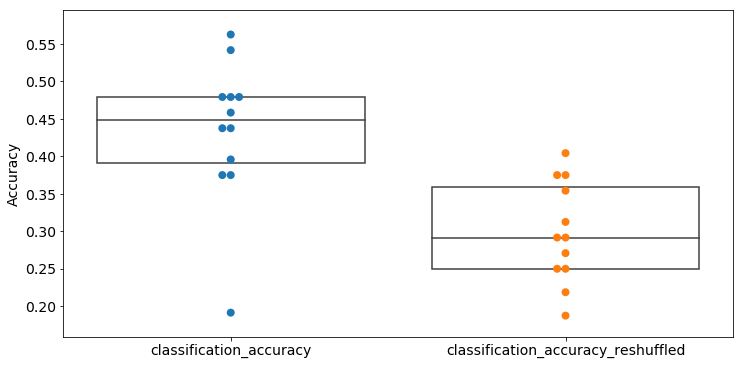

In [16]:
from helper_functions import plot_classification_accuracies
plot_classification_accuracies(classification_results)